# Import Pre-trained YOLOv8 model

In [1]:
!pip install ultralytics


DEPRECATION: Loading egg at /Users/alanluke/miniconda3/lib/python3.11/site-packages/mask_rcnn-2.1-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [2]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

DEPRECATION: Loading egg at /Users/alanluke/miniconda3/lib/python3.11/site-packages/mask_rcnn-2.1-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
  Cloning https://github.com/facebookresearch/segment-anything.git to /private/var/folders/bj/g3sgj86961v6pk4hm7rg_mmm0000gn/T/pip-req-build-otoarvql
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /private/var/folders/bj/g3sgj86961v6pk4hm7rg_mmm0000gn/T/pip-req-build-otoarvql
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
zsh:1: command not found: wget


In [3]:
from ultralytics import YOLO

yolo_model = YOLO('/Users/alanluke/Desktop/LukZ/Dev/final-year-project/COR_MODEL/Data Conversion/yolo_dataset/results/200_epochs-3/weights/best.pt')

In [7]:
results = yolo_model.predict(source='/Users/alanluke/Desktop/LukZ/Dev/final-year-project/COR_MODEL/Data Conversion/yolo_dataset/VM/valid/images/2294008cor_1_1_1_16.png', conf=0.20)


image 1/1 /Users/alanluke/Desktop/LukZ/Dev/final-year-project/COR_MODEL/Data Conversion/yolo_dataset/VM/valid/images/2294008cor_1_1_1_16.png: 800x800 2 VMs, 94.5ms
Speed: 3.5ms preprocess, 94.5ms inference, 1.4ms postprocess per image at shape (1, 3, 800, 800)


In [8]:
results

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: ultralytics.engine.results.Masks object
 names: {0: 'VM'}
 obb: None
 orig_img: array([[[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [86, 86, 86],
         [81, 81, 81],
         [80, 80, 80]],
 
        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [86, 86, 86],
         [81, 81, 81],
         [80, 80, 80]],
 
        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [90, 90, 90],
         [84, 84, 84],
         [83, 83, 83]],
 
        ...,
 
        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],
 
        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]]

In [35]:
for result in results:
    boxes = result.boxes

bbox=boxes.xyxy.tolist()
bbox_length = len(bbox)
print("Length of bbox:", bbox_length)

Length of bbox: 2


# SAM Instance Segmentation
Feed the bounding boxes and the image to SAM and let it do the masking

In [12]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from IPython.display import display, Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [13]:
sam_checkpoint = "/Users/alanluke/Desktop/LukZ/Dev/final-year-project/sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam_model = sam_model_registry[model_type](checkpoint=sam_checkpoint)
predictor = SamPredictor(sam_model)

In [14]:
image = cv2.cvtColor(cv2.imread('/Users/alanluke/Desktop/LukZ/Dev/final-year-project/COR_MODEL/Data Conversion/yolo_dataset/VM/valid/images/2294008cor_1_1_1_16.png'), cv2.COLOR_BGR2RGB)
predictor.set_image(image)

In [65]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [ ]:
input_box = np.array(bbox)

masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

segmentation_mask = masks[0]
binary_mask = np.where(segmentation_mask > 0.5, 1, 0)

black_background = np.ones_like(image)*0

mask_color = np.array([255, 255, 255])  # White color

new_image = black_background * (1 - binary_mask[..., np.newaxis]) + mask_color * binary_mask[..., np.newaxis]

plt.imshow(new_image.astype(np.uint8))
plt.axis('off')
plt.show()

COMBINATION



image 1/1 /Users/alanluke/Desktop/LukZ/Dev/final-year-project/COR_MODEL/Data Conversion/yolo_dataset/VM/train/images/2273970cor_1_1_1_9.png: 800x800 2 VMs, 95.2ms
Speed: 1.9ms preprocess, 95.2ms inference, 1.4ms postprocess per image at shape (1, 3, 800, 800)


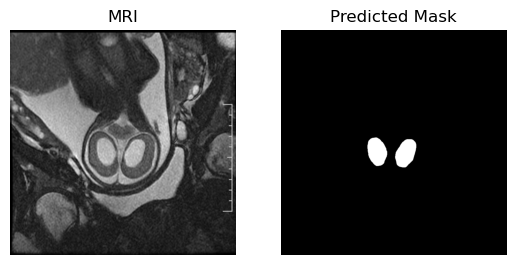

In [42]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

yolo_model = YOLO('/Users/alanluke/Desktop/LukZ/Dev/final-year-project/COR_MODEL/Data Conversion/yolo_dataset/results/200_epochs-3/weights/best.pt')
results = yolo_model.predict(source='/Users/alanluke/Desktop/LukZ/Dev/final-year-project/COR_MODEL/Data Conversion/yolo_dataset/VM/train/images/2273970cor_1_1_1_9.png', conf=0.20)

sam_checkpoint = "/Users/alanluke/Desktop/LukZ/Dev/final-year-project/sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam_model = sam_model_registry[model_type](checkpoint=sam_checkpoint)
predictor = SamPredictor(sam_model)

segmented_images = []

for result in results:
    boxes = result.boxes
    bbox = boxes.xyxy.tolist()

for i in range(len(bbox)):
    bbox = boxes.xyxy.tolist()[i]
    image = cv2.cvtColor(cv2.imread('/Users/alanluke/Desktop/LukZ/Dev/final-year-project/COR_MODEL/Data Conversion/yolo_dataset/VM/train/images/2273970cor_1_1_1_9.png'), cv2.COLOR_BGR2RGB)
    predictor.set_image(image)
    input_box = np.array(bbox)

    masks, _, _ = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=input_box[None, :],
        multimask_output=False,
    )

    segmentation_mask = masks[0]
    binary_mask = np.where(segmentation_mask > 0.5, 1, 0)

    black_background = np.ones_like(image) * 0
    mask_color = np.array([255, 255, 255])  

    
    new_image = black_background * (1 - binary_mask[..., np.newaxis]) + mask_color * binary_mask[..., np.newaxis]
    segmented_images.append(new_image)

overlayed_image = np.zeros_like(image)

for new_image in segmented_images:
    overlayed_image = overlayed_image * (1 - new_image) + new_image


plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')
plt.title('MRI')

plt.subplot(1, 2, 2)
plt.imshow(overlayed_image.astype(np.uint8))
plt.axis('off')
plt.title('Predicted Mask')

plt.show()
